In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# What we are doing in this cell:-

1. Downloading the data set.
2. Giving the data appropriate labels.
3. Creating a custom data class animal_data for the class.
4. Created data loders for training, validation and testing sets.

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

class AnimalData(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.dataset = ImageFolder(root=self.data_dir, transform=self.transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Get the item from the dataset
        image, label = self.dataset[idx]

        # Move the image tensor to GPU
        image = image.to(torch.device('cuda'))

        return image, label

# Define the parameters
data_dir = "/content/drive/MyDrive/Russian_WildLife_Dataset"

class_mapping = {
    'amur_leopard': 0,
    'amur_tiger': 1,
    'birds': 2,
    'black_bear': 3,
    'brown_bear': 4,
    'dog': 5,
    'roe_deer': 6,
    'sika_deer': 7,
    'wild_boar': 8,
    'people': 9
}

# Using a dictionary comprehension to reverse the key-value pairs
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# Define the parameters
image_size = 128  # Fixed image size
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to black and white
    transforms.Resize(image_size),  # Resize images to 256x256 pixels
    transforms.CenterCrop((image_size, image_size)),  # Center crop to ensure all images have the same size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Mean and std for a single channel
])

# Create dataset using AnimalData
animal_data = AnimalData(data_dir=data_dir, transform=transform)

import torch
from torch.utils.data import DataLoader, random_split

# Define the ratio for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Calculate the sizes of each set
num_data = len(animal_data)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_data, val_data, test_data = random_split(animal_data, [num_train, num_val, num_test])

batch_size = 32

# Move datasets to GPU
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Function to move data loader to GPU
def move_to_gpu(data_loader):
    for batch in data_loader:
        yield [item.to(torch.device('cuda')) for item in batch]

# Move data loaders to GPU
train_loader = move_to_gpu(train_loader)
val_loader = move_to_gpu(val_loader)
test_loader = move_to_gpu(test_loader)

# Print the sizes of each set
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))

Train set size: 9019
Validation set size: 1288
Test set size: 2578


# What we are doing in this cell:-
1. Initialised weights and biases

In [5]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [6]:
import wandb

# Initialize WandB with your project name and optionally specify the entity (e.g., your username or team name)
wandb.init(project="question_2_computer_vision", entity="mjzeus1729")

# Optionally, you can also specify other configurations such as the experiment name or group
wandb.init(project="Q2_1", entity="mjzeus1729", name="computer_vision_hw_1", group="mjzeus1729")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# What we are doing here:-
1. We will count the frequency of each data label in training and validation data.

In [ ]:
import matplotlib.pyplot as plt

# Global variables to store the count values
global_training_class_counts = [0] * 10
global_validation_class_counts = [0] * 10

# Function to visualize data distribution for the first 5 images in the training set
def visualize_training_data_distribution(dataset, title):
    global global_training_class_counts
    class_counts = [0] * 10
    for idx, (image, label) in enumerate(dataset):
        if idx % 4 == 0:  # Take only images with index as multiple of 4
            class_counts[label] += 1
    class_counts = [count * 4 for count in class_counts]  # Multiply counts by 4
    global_training_class_counts = class_counts  # Update global variable
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), class_counts)  # Use range(10) as x-axis for class labels
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10))  # Set x-ticks to represent class labels from 0 to 9
    plt.show()

# Function to visualize data distribution for the first 5 images in the validation set
def visualize_validation_data_distribution(dataset, title):
    global global_validation_class_counts
    class_counts = [0] * 10
    for idx, (image, label) in enumerate(dataset):
        if idx % 2 == 0:  # Take only images with even index
            class_counts[label] += 1
    class_counts = [count * 2 for count in class_counts]  # Multiply counts by 2
    global_validation_class_counts = class_counts  # Update global variable
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), class_counts)  # Use range(10) as x-axis for class labels
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(10))  # Set x-ticks to represent class labels from 0 to 9
    plt.show()

# Visualize data distribution for the first 5 images in the training set
visualize_training_data_distribution(train_data, 'Training Set Data Distribution (First 5 Images)')

# Visualize data distribution for the first 5 images in the validation set
visualize_validation_data_distribution(val_data, 'Validation Set Data Distribution (First 5 Images)')

KeyboardInterrupt: 

# After running this code once i got the following values for the frequency of training and validation data.

In [ ]:
global_training_class_counts = [724, 760, 956, 772, 808, 936, 984, 896, 1096, 1092]
global_validation_class_counts = [114, 92, 170, 106, 112, 138, 150, 114, 166, 126]

# Following are several data visualization cells.

In [ ]:
plt.figure(figsize=(10, 5))
classes = [0,1,2,3,4,5,6,7,8,9]
plt.bar(classes, global_training_class_counts, color='blue')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Training Data Set Distribution')
plt.show()

# Plotting Validation Data Set Distribution
plt.figure(figsize=(10, 5))
plt.bar(classes, global_validation_class_counts, color='red')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Validation Data Set Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
classes = [0,1,2,3,4,5,6,7,8,9]
plt.pie(global_training_class_counts, labels=classes, autopct='%1.1f%%')
plt.title('Training Data Set Distribution')
plt.show()

In [ ]:
plt.figure(figsize=(8, 8))
classes = [0,1,2,3,4,5,6,7,8,9]
plt.pie(global_validation_class_counts, labels=classes, autopct='%1.1f%%')
plt.title('Validation Data Set Distribution')
plt.show()

In [ ]:
import numpy as np

bar_width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(classes, global_training_class_counts, bar_width, label='Training', color='blue')
plt.bar(np.array(classes) + bar_width, global_validation_class_counts, bar_width, label='Validation', color='red')
plt.xlabel('Class')
plt.ylabel('Counts')
plt.title('Data Set Distribution')
plt.xticks(np.array(classes) + bar_width / 2, classes)
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.violinplot(dataset=[global_training_class_counts, global_validation_class_counts], showmeans=True)
plt.xticks([1, 2], ['Training', 'Validation'])
plt.ylabel('Counts')
plt.title('Data Set Distribution')
plt.show()

In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. GPU will be used.")
else:
    print("CUDA is not available. Switching to CPU.")

CUDA is not available. Switching to CPU.


# Now we create a subset of the data loader for trial purposes

In [ ]:
import random

# Function to create a new data loader with a subset of data
def create_subset_data_loader(dataset, batch_size, subset_percentage):
    subset_size = int(len(dataset) * subset_percentage)
    subset_indices = random.sample(range(len(dataset)), subset_size)
    subset_data = torch.utils.data.Subset(dataset, subset_indices)
    return torch.utils.data.DataLoader(subset_data, batch_size=batch_size, shuffle=True)

# Use the same batch size as defined in Cell 2
batch_size = 8

# Create new data loaders with 10% of the data randomly selected from the original datasets
train_loader = create_subset_data_loader(train_data, batch_size, 0.1)
val_loader = create_subset_data_loader(val_data, batch_size, 0.1)
test_loader = create_subset_data_loader(test_data, batch_size, 0.1)

print(len(train_loader), len(val_loader), len(test_loader))

113 16 33


# Create the manually written CNN model here.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # First Convolutional Layer: 3x3 kernel, 32 input channels, 32 output channels
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 4x4 kernel, stride 4
        self.maxpool1 = nn.MaxPool2d(kernel_size=4, stride=4)

        # Second Convolutional Layer: 3x3 kernel, 32 input channels, 64 output channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 kernel, stride 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third Convolutional Layer: 3x3 kernel, 64 input channels, 128 output channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        # Max pooling layer: 2x2 kernel, stride 2
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute the size of the output of the third convolutional layer
        # This is needed to calculate the input size of the fully connected layer
        self.conv3_output_size = self._calculate_conv3_output_size()

        # Fully connected layer
        self.fc = nn.Linear(128 * self.conv3_output_size * self.conv3_output_size, 10)

    def forward(self, x):
        # First Convolutional Layer
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        # Second Convolutional Layer
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        # Third Convolutional Layer
        x = F.relu(self.conv3(x))
        x = self.maxpool3(x)

        # Flatten the output for the fully connected layer
        x = x.view(-1, 128 * self.conv3_output_size * self.conv3_output_size)

        # Fully connected layer
        x = self.fc(x)
        return x

    def _calculate_conv3_output_size(self):
        # Function to calculate the output size of the third convolutional layer
        # Assuming input image size of 128x128 pixels
        input_size = 128
        conv1_output_size = (input_size + 2 * 1 - 3) // 1 + 1  # Conv1 output size with padding=1 and kernel_size=3
        maxpool1_output_size = conv1_output_size // 4  # MaxPool1 output size with kernel_size=4, stride=4
        conv2_output_size = (maxpool1_output_size + 2 * 1 - 3) // 1 + 1  # Conv2 output size with padding=1 and kernel_size=3
        maxpool2_output_size = conv2_output_size // 2  # MaxPool2 output size with kernel_size=2, stride=2
        conv3_output_size = (maxpool2_output_size + 2 * 1 - 3) // 1 + 1  # Conv3 output size with padding=1 and kernel_size=3
        maxpool3_output_size = conv3_output_size // 2  # MaxPool3 output size with kernel_size=2, stride=2
        return maxpool3_output_size

# Instantiate the model
model = CNN()

# Send the model and the data loaders to the gpu

In [ ]:
# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU if available
model.to(device)

# Inside the training loop, move the input data to the same device as the model
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

# Learning

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import wandb

# Assuming you have defined the model, train_loader, val_loader, and moved them to GPU as shown in the previous code snippets

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize WandB
wandb.init(project="Q2_2", entity="mjzeus1729", name="computer_vision_hw_1", group="mjzeus1729")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Define the number of epochs
num_epochs = 10  # Training for 10 epochs

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:  # Using the new 1% data loader
        # Move inputs and labels to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Compute training statistics
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    # Compute training accuracy and loss
    train_accuracy = correct_train / total_train
    train_loss = train_loss / len(train_loader.dataset)

    # Set model to evaluation mode
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:  # Using the new 1% data loader
            # Move inputs and labels to GPU if available
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Compute validation statistics
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Compute validation accuracy and loss
    val_accuracy = correct_val / total_val
    val_loss = val_loss / len(val_loader.dataset)

    # Log training and validation metrics to wandb
    wandb.log({"Epoch": epoch+1, "Train Loss": train_loss, "Train Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy})

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

# Finish logging
wandb.finish()

# Print final results
print("Training completed!")
print(f"Final Train Loss: {train_loss:.4f}, Final Train Acc: {train_accuracy:.4f}, Final Val Loss: {val_loss:.4f}, Final Val Acc: {val_accuracy:.4f}")

Epoch 1/10, Train Loss: 2.3308, Train Acc: 0.1444, Val Loss: 2.3129, Val Acc: 0.1172
Epoch 2/10, Train Loss: 2.1778, Train Acc: 0.2667, Val Loss: 2.4151, Val Acc: 0.1484
Epoch 3/10, Train Loss: 1.9841, Train Acc: 0.3333, Val Loss: 2.5906, Val Acc: 0.1719
Epoch 4/10, Train Loss: 1.7895, Train Acc: 0.4444, Val Loss: 3.0657, Val Acc: 0.1562
Epoch 5/10, Train Loss: 1.6754, Train Acc: 0.4333, Val Loss: 3.3163, Val Acc: 0.1641
Epoch 6/10, Train Loss: 1.5004, Train Acc: 0.4667, Val Loss: 3.8346, Val Acc: 0.1562
Epoch 7/10, Train Loss: 1.2964, Train Acc: 0.5778, Val Loss: 4.1979, Val Acc: 0.1562
Epoch 8/10, Train Loss: 1.0768, Train Acc: 0.6556, Val Loss: 5.2274, Val Acc: 0.1875
Epoch 9/10, Train Loss: 0.9395, Train Acc: 0.7222, Val Loss: 5.1257, Val Acc: 0.1641
Epoch 10/10, Train Loss: 1.1669, Train Acc: 0.7000, Val Loss: 5.0402, Val Acc: 0.1719


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▂▃▅▅▅▆▇██
Train Loss,█▇▆▅▅▄▃▂▁▂
Validation Accuracy,▁▄▆▅▆▅▅█▆▆
Validation Loss,▁▁▂▃▃▅▆███
Epoch,10
Train Accuracy,0.7
Train Loss,1.16687
Validation Accuracy,0.17188
Validation Loss,5.0402


Training completed!
Final Train Loss: 1.1669, Final Train Acc: 0.7000, Final Val Loss: 5.0402, Final Val Acc: 0.1719


# Testing

In [ ]:
import torch
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import wandb

# Set the model to evaluation mode
model.eval()

wandb.init(project="Q2_2", entity="mjzeus1729", name="computer_vision_hw_1", group="mjzeus1729")

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test data loader
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Get predicted labels
        _, predicted = torch.max(outputs, 1)

        # Append true and predicted labels to the lists
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate accuracy and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Log accuracy and F1-score to wandb
wandb.log({"Test Accuracy": accuracy, "Test F1-Score": f1})

# Log confusion matrix to wandb
wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None,
                                                            y_true=true_labels,
                                                            preds=predicted_labels,
                                                            class_names=[str(i) for i in range(10)])})

# Print accuracy and F1-score
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

wandb: Currently logged in as: mjzeus1729. Use `wandb login --relogin` to force relogin


Test Accuracy: 0.2879
Test F1-Score: 0.2438


# We change the data preprocessing steps and Create the Pretrained Resnet-18 model here

In [ ]:
# Define the parameters
image_size = 128  # Fixed image size
transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize images to 256x256 pixels
    transforms.RandomCrop(size=(image_size, image_size)),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Mean and std for a single channel
])

# Create dataset using AnimalData
animal_data = AnimalData(data_dir=data_dir, transform=transform)

import torch
from torch.utils.data import DataLoader, random_split

# Define the ratio for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Calculate the sizes of each set
num_data = len(animal_data)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_data, val_data, test_data = random_split(animal_data, [num_train, num_val, num_test])

BATCH_SIZE = 32

batch_size = BATCH_SIZE

# Move datasets to GPU
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(len(train_data), len(val_data), len(test_data))
print(len(train_loader), len(val_loader), len(test_loader))

# Function to move data loader to GPU
def move_to_gpu(data_loader):
    for batch in data_loader:
        yield [item.to(torch.device('cuda')) for item in batch]

# Move data loaders to GPU
train_loader = move_to_gpu(train_loader)
val_loader = move_to_gpu(val_loader)
test_loader = move_to_gpu(test_loader)

import random

# Function to create a new data loader with a subset of data
def create_subset_data_loader(dataset, batch_size, subset_percentage):
    subset_size = int(len(dataset) * subset_percentage)
    subset_indices = random.sample(range(len(dataset)), subset_size)
    subset_data = torch.utils.data.Subset(dataset, subset_indices)
    return torch.utils.data.DataLoader(subset_data, batch_size=batch_size, shuffle=True)

# Use the same batch size as defined in Cell 2
batch_size = BATCH_SIZE

# Create new data loaders with 10% of the data randomly selected from the original datasets
train_loader = create_subset_data_loader(train_data, batch_size, 1)

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

# Move the model to the GPU if available
model.to(device)

# Inside the training loop, move the input data to the same device as the model
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)

9019 1288 2578
282 41 81


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Move model to training mode
model.train()

# Initialize WandB with your project name and optionally specify the entity
wandb.init(project="question_2_computer_vision", entity="mjzeus1729")

# Loop over the dataset for a number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Log training and validation loss and accuracy to WandB
    wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy}, step=epoch)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

Training Accuracy,▁▇██▇█████
Training Loss,█▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▆▆▇▇▇██▇
Validation Loss,█▃▂▃▅▃▄▄▁▃
Training Accuracy,95.55556
Training Loss,0.19076
Validation Accuracy,29.65839
Validation Loss,8.31448


Epoch 1/10, Training Loss: 2.8186, Training Accuracy: 39.55%, Validation Loss: 1.5655, Validation Accuracy: 52.02%
Epoch 2/10, Training Loss: 1.2215, Training Accuracy: 58.24%, Validation Loss: 1.1329, Validation Accuracy: 60.64%
Epoch 3/10, Training Loss: 0.9400, Training Accuracy: 67.72%, Validation Loss: 1.2286, Validation Accuracy: 60.95%
Epoch 4/10, Training Loss: 0.7458, Training Accuracy: 75.60%, Validation Loss: 1.0194, Validation Accuracy: 65.06%
Epoch 5/10, Training Loss: 0.6198, Training Accuracy: 78.48%, Validation Loss: 1.7355, Validation Accuracy: 54.74%
Epoch 6/10, Training Loss: 0.6371, Training Accuracy: 77.93%, Validation Loss: 1.2368, Validation Accuracy: 61.88%
Epoch 7/10, Training Loss: 0.6105, Training Accuracy: 79.87%, Validation Loss: 1.3510, Validation Accuracy: 60.87%
Epoch 8/10, Training Loss: 0.5161, Training Accuracy: 81.92%, Validation Loss: 1.1509, Validation Accuracy: 65.76%
Epoch 9/10, Training Loss: 0.4214, Training Accuracy: 85.80%, Validation Loss: 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

# Put the model in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate accuracy and F1-score
test_accuracy = accuracy_score(true_labels, predicted_labels) * 100
test_f1_score = f1_score(true_labels, predicted_labels, average='macro')

# Log accuracy and F1-score to WandB
wandb.log({"Test Accuracy": test_accuracy, "Test F1-Score": test_f1_score})

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Log confusion matrix to WandB
wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=predicted_labels)})

# Print test accuracy and F1-score
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1-Score: {test_f1_score:.4f}")


Test Accuracy: 74.67%
Test F1-Score: 0.7513


# Visualise the tSNE plot of Validation set in 2D space and 3D space

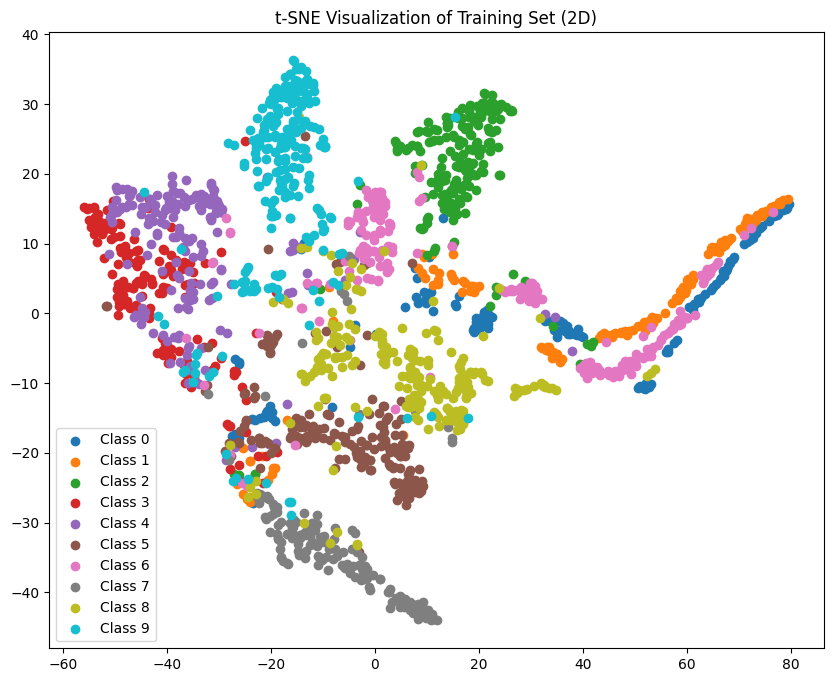

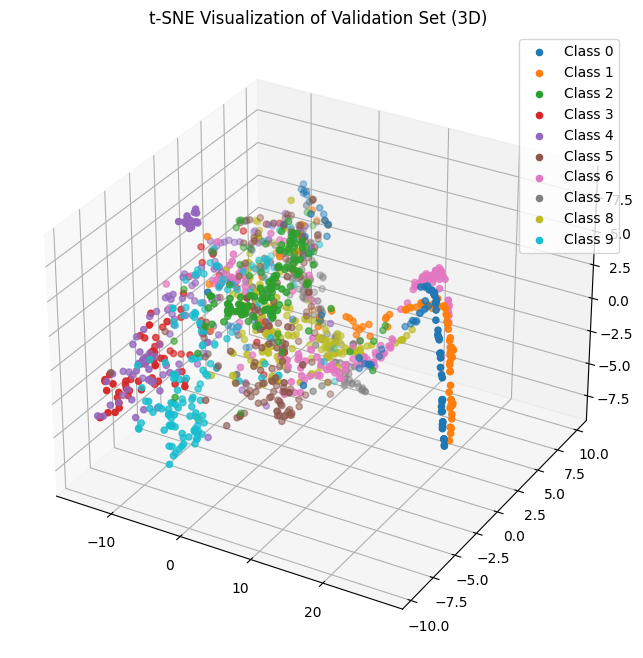

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract feature vectors for training set
train_features = []
train_labels = []
with torch.no_grad():
    for train_inputs, train_labels_batch in train_loader:
        train_inputs = train_inputs.to(device)
        train_features_batch = model(train_inputs).cpu().numpy()
        train_features.append(train_features_batch)
        train_labels.append(train_labels_batch.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

# Extract feature vectors for validation set
val_features = []
val_labels = []
with torch.no_grad():
    for val_inputs, val_labels_batch in val_loader:
        val_inputs = val_inputs.to(device)
        val_features_batch = model(val_inputs).cpu().numpy()
        val_features.append(val_features_batch)
        val_labels.append(val_labels_batch.cpu().numpy())

val_features = np.concatenate(val_features, axis=0)
val_labels = np.concatenate(val_labels, axis=0)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
train_features_2d = tsne.fit_transform(train_features)

# Visualize in 2D space
plt.figure(figsize=(10, 8))
for class_label in np.unique(train_labels):
    indices = train_labels == class_label
    plt.scatter(train_features_2d[indices, 0], train_features_2d[indices, 1], label=f'Class {class_label}')
plt.title('t-SNE Visualization of Training Set (2D)')
plt.legend()
plt.show()

# Perform t-SNE dimensionality reduction for validation set (3D)
tsne_3d = TSNE(n_components=3, random_state=42)
val_features_3d = tsne_3d.fit_transform(val_features)

# Visualize in 3D space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
for class_label in np.unique(val_labels):
    indices = val_labels == class_label
    ax.scatter(val_features_3d[indices, 0], val_features_3d[indices, 1], val_features_3d[indices, 2], label=f'Class {class_label}')
ax.set_title('t-SNE Visualization of Validation Set (3D)')
ax.legend()
plt.show()

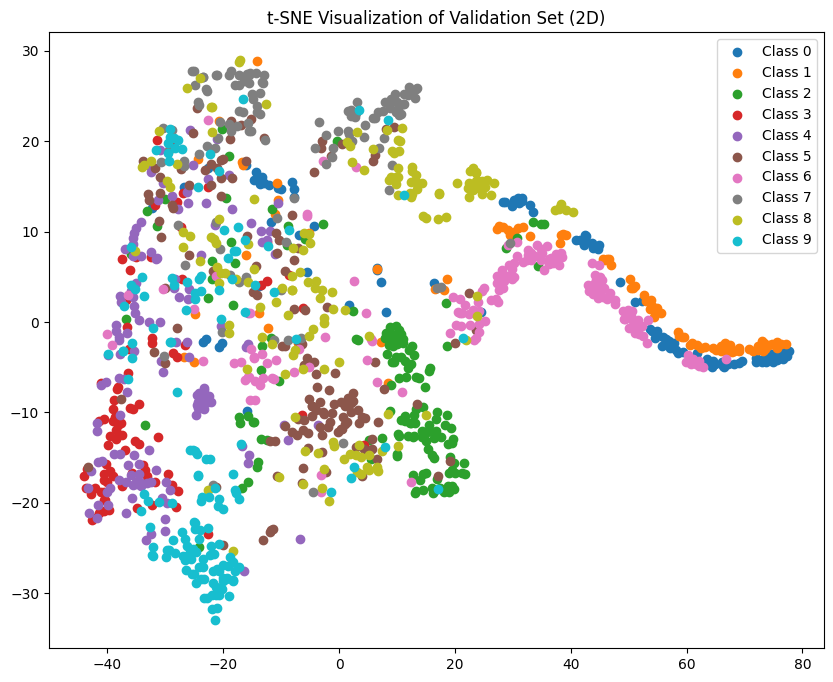

In [ ]:
# Perform t-SNE dimensionality reduction for validation set (2D)
tsne_val = TSNE(n_components=2, random_state=42)
val_features_2d = tsne_val.fit_transform(val_features)

# Visualize in 2D space
plt.figure(figsize=(10, 8))
for class_label in np.unique(val_labels):
    indices = val_labels == class_label
    plt.scatter(val_features_2d[indices, 0], val_features_2d[indices, 1], label=f'Class {class_label}')
plt.title('t-SNE Visualization of Validation Set (2D)')
plt.legend()
plt.show()

# Data Augmentation

In [12]:
# Define the parameters
image_size = 128  # Fixed image size

transform = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5),  # Random perspective
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Random contrast
    transforms.ColorJitter(saturation=0.5),  # Random saturation
    transforms.Resize(image_size),  # Resize images to 128x128 pixels
    transforms.RandomCrop(size=(image_size, image_size)),  # Random crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Mean and std for a single channel
])

# Create dataset using AnimalData
animal_data = AnimalData(data_dir=data_dir, transform=transform)

import torch
from torch.utils.data import DataLoader, random_split

# Define the ratio for train, validation, and test sets
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Calculate the sizes of each set
num_data = len(animal_data)
num_train = int(train_ratio * num_data)
num_val = int(val_ratio * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_data, val_data, test_data = random_split(animal_data, [num_train, num_val, num_test])

BATCH_SIZE = 32

batch_size = BATCH_SIZE

# Move datasets to GPU
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Function to move data loader to GPU
def move_to_gpu(data_loader):
    for batch in data_loader:
        yield [item.to(torch.device('cuda')) for item in batch]

# Move data loaders to GPU
train_loader_gpu = move_to_gpu(train_loader)
val_loader_gpu = move_to_gpu(val_loader)
test_loader_gpu = move_to_gpu(test_loader)

import random

# Function to create a new data loader with a subset of data
def create_subset_data_loader(dataset, batch_size, subset_percentage):
    subset_size = int(len(dataset) * subset_percentage)
    subset_indices = random.sample(range(len(dataset)), subset_size)
    subset_data = torch.utils.data.Subset(dataset, subset_indices)
    return torch.utils.data.DataLoader(subset_data, batch_size=batch_size, shuffle=True)

# Use the same batch size as defined in Cell 2
batch_size = BATCH_SIZE

# Create new data loaders with 10% of the data randomly selected from the original datasets
train_loader_gpu = create_subset_data_loader(train_data, batch_size, 0.01)

# Define the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
model.eval()

# Move the model to the GPU if available
model.to(device)

# Inside the training loop, move the input data to the same device as the model
for inputs, labels in train_loader_gpu:
    inputs, labels = inputs.to(device), labels.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import wandb

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Move model to training mode
model.train()

# Initialize WandB with your project name and optionally specify the entity
wandb.init(project="question_2_computer_vision", entity="mjzeus1729")

# Loop over the dataset for a number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    model.train()
    for inputs, labels in train_loader_gpu:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_labels in val_loader_gpu:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    # Log training and validation loss and accuracy to WandB
    wandb.log({"Training Loss": train_loss, "Training Accuracy": train_accuracy, "Validation Loss": val_loss, "Validation Accuracy": val_accuracy}, step=epoch)

    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

# Put the model in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        true_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(test_predicted.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate accuracy and F1-score
test_accuracy = accuracy_score(true_labels, predicted_labels) * 100
test_f1_score = f1_score(true_labels, predicted_labels, average='macro')

# Log accuracy and F1-score to WandB
wandb.log({"Test Accuracy": test_accuracy, "Test F1-Score": test_f1_score})

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Log confusion matrix to WandB
wandb.log({"Confusion Matrix": wandb.plot.confusion_matrix(probs=None, y_true=true_labels, preds=predicted_labels)})

# Print test accuracy and F1-score
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test F1-Score: {test_f1_score:.4f}")
